In [1]:
RANDOM_SEED = 2306406

# Opening data

In [2]:
import pandas as pd 

url = "https://raw.githubusercontent.com/yiweiluo/GWStance/refs/heads/master/3_stance_detection/1_MTurk/full_annotations.tsv"
df_raw = pd.read_csv(url, sep = "\t") # Careful here, this document is a tsv (separator="\t" and not a csv (separator = ",")

df_raw.head()

,Unnamed: 0,MACE_pred,av_rating,sentence,worker_0,worker_1,worker_2,worker_3,worker_4,worker_5,worker_6,worker_7,round,batch,sent_id,disagree,agree,neutral
0,0,disagrees,-1.000,Global warming is a hoax.,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,disagrees,1,0,s0,NaN,NaN,NaN
1,1,neutral,0.375,Alarming levels of sea level rise are predicte...,neutral,neutral,neutral,agrees,agrees,neutral,neutral,agrees,1,0,s1,NaN,NaN,NaN
2,2,neutral,0.000,"Over the past several years, the United States...",neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,1,0,s2,NaN,NaN,NaN
3,3,agrees,1.000,Global warming is happening and it will be dan...,agrees,agrees,agrees,agrees,agrees,agrees,agrees,agrees,1,0,s3,NaN,NaN,NaN
4,4,neutral,0.000,Some icebergs are cute.,neutral,neutral,neutral,neutral,neutral,neutral,neutral,neutral,1,0,s4,NaN,NaN,NaN


In [3]:
df = df_raw.loc[:,["sent_id", "sentence", "MACE_pred", "av_rating"]]
df = df.rename(columns={"MACE_pred" : "label_text"}) # Rename MACE_pred for conveniency

In [4]:
df.groupby(["label_text"]).size()

label_text
agrees       871
disagrees    441
neutral      988
dtype: int64

,count,mean,std,min,25%,50%,75%,max
label_text,,,,,,,,
agrees,871.0,114.910448,56.008241,22.0,77.0,100.0,148.0,342.0
disagrees,441.0,98.090703,59.093654,22.0,51.0,86.0,134.0,325.0
neutral,988.0,110.731781,54.436786,21.0,72.0,104.0,148.0,347.0


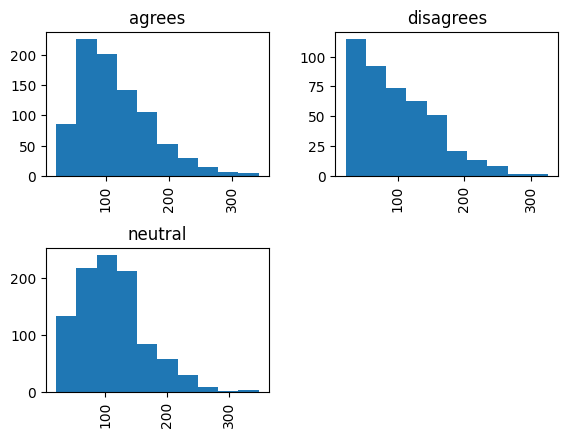

In [5]:
df["sentence-len"] = df["sentence"].apply(len)
df.hist(column = "sentence-len", by="label_text")
df.groupby("label_text")["sentence-len"].describe()

count    2300.000000
mean      109.890435
std        56.251317
min        21.000000
25%        70.000000
50%       100.000000
75%       145.000000
max       347.000000
Name: sentence-len, dtype: float64

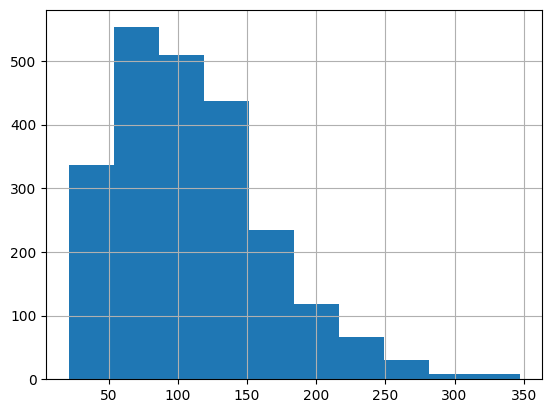

In [6]:
df["sentence-len"].hist()
df["sentence-len"].describe()

# Preprocessing data

In [7]:
def preprocess_text(text: str):
    if not(isinstance(text, str)):
        return pd.NA
    return (
        text
        .replace("’", "'")
        .replace("``", '"')
        .replace("''", '"')
        .replace(" ,", ",")
        .replace(" .", ".")
        .replace(" !", "!")
        .replace(" ?", "?")
        .replace(" :", ":")
        .replace(" 's", "'s")
    )
df["sentence-preprocessed"] = df["sentence"].apply(preprocess_text)

In [8]:
df.groupby("sentence-preprocessed").size().value_counts()

1     2032
2        9
50       5
Name: count, dtype: int64

In [9]:
df_no_duplicates = df.loc[~df["sent_id"].str.startswith("s"), :] 
df_no_duplicates.groupby("sentence-preprocessed").size().value_counts()

1    2032
2       9
Name: count, dtype: int64

In [10]:
df_concensus = df_no_duplicates.groupby("sentence-preprocessed")["label_text"].agg(concensus = lambda X : len(set(X)) == 1)
df_concensus[df_concensus["concensus"] == False]

,concensus
sentence-preprocessed,
We need to get rid of fossil fuel subsidies now.,False


In [11]:
df_no_duplicates = df_no_duplicates.loc[
    df_no_duplicates["sentence-preprocessed"] != "We need to get rid of fossil fuel subsidies now.",
    :
]
df_no_duplicates = df_no_duplicates.drop_duplicates("sentence-preprocessed")

In [12]:
from Levenshtein import distance as lev_distance

threshold = 10

# Dont run, it's annoyingly long

# with open("Levenshtein-duplicates.txt", "w") as file:
#     file.write("")

# for i in range(len(df_no_duplicates)):
#     for j in range(i + 1, len(df_no_duplicates)):
#         s1 = df_no_duplicates.iloc[i]["sentence-preprocessed"]
#         s2 = df_no_duplicates.iloc[j]["sentence-preprocessed"]
#         d = lev_distance(s1, s2)
#         if d < threshold:
#             with open("Levenshtein-duplicates.txt", "a") as file:
#                 file.write(f"{d} : {s1} || {s2}\n")

In [13]:
last_duplicates = [
    ("There is no solid evidence of global warming.","There is not solid evidence of global warming."),
    ("Balance of evidence suggests a discernible human influence on global climate.","The balance of evidence suggests a discernible human influence on global climate."),
    ("The alleged “ consensus ” behind the dangers of anthropogenic global warming is not nearly as settled among climate scientists as people imagine.","The alleged â consensus â behind the dangers of anthropogenic global warming is not nearly as settled among climate scientists as people imagine."),
    ("Rising global temperatures during the 19th and 20th centuries may be linked to greater plant photosynthesis.","Rising global temperatures during the 19th and 20th centuries could be linked to greater plant photosynthesis."),
    ("Climate change will continue to affect all types of weather phenomena and subsequently impact increasingly urbanised areas.","Climate change will continue to affect all types of weather phenomena and subsequently impact increasingly urbanized areas."),
]

for (s1, s2) in last_duplicates:
    lab_s1 = df_no_duplicates.loc[df_no_duplicates["sentence"] == s1, "label_text"]
    lab_s2 = df_no_duplicates.loc[df_no_duplicates["sentence"] == s2, "label_text"]
    if lab_s1.item() == lab_s2.item() : 
        df_no_duplicates.drop(index = lab_s2.index)
    else: 
        df_no_duplicates.drop(index = [*lab_s1.index, *lab_s2.index])

In [14]:
import numpy as np 
# Create splits 
N = len(df_no_duplicates)
N_train = int(N * 0.7)
N_train_eval = int(N * 0.1)
N_test = int(N * 0.1)
N_final_eval = N - N_train - N_train_eval - N_test 

assert N_final_eval > 0


indices = df_no_duplicates.index.to_series()
indices_train = (
    indices
    .sample(n = N_train, random_state=RANDOM_SEED)
)
indices_train_eval = (
    indices
    .drop(index=indices_train.index)
    .sample(n = N_train_eval, random_state=RANDOM_SEED)
)
indices_test = (
    indices
    .drop(index=[*indices_train.index, *indices_train_eval.index])
    .sample(n = N_train_eval, random_state=RANDOM_SEED)
)
indices_final_test = (
    indices
    .drop(index = [*indices_train, *indices_train_eval,*indices_test])
)


In [35]:
df_split = (
    pd.concat({
        "train"         : df_no_duplicates.loc[indices_train      , :],
        "train_eval"    : df_no_duplicates.loc[indices_train_eval , :],
        "test"          : df_no_duplicates.loc[indices_test       , :],
        "final_test"     : df_no_duplicates.loc[indices_final_test  , :],
    })
    .reset_index()
    .drop(columns=["level_1"])
    .rename(columns = {"level_0": "split"})
)
df_split.to_csv("./data/GWStance_preprocessed.csv", index = False)

In [36]:
df_split

,split,sent_id,sentence,label_text,av_rating,sentence-len,sentence-preprocessed
0,train,t4,There is a definite declining trend in Arctic ...,agrees,0.500,54,There is a definite declining trend in Arctic ...
1,train,t38,Human-made climate change is a real and urgent...,agrees,0.750,138,Human-made climate change is a real and urgent...
2,train,t8,I can tell you that a lot of what happens â ...,agrees,0.875,216,I can tell you that a lot of what happens â ...
3,train,t42,It is the third time in 40 years in which warm...,neutral,-0.250,73,It is the third time in 40 years in which warm...
4,train,t18,A runaway greenhouse effect on Venus led to te...,neutral,0.125,81,A runaway greenhouse effect on Venus led to te...
...,...,...,...,...,...,...,...
2035,final_test,t17,No one can come to Davos anymore and not under...,neutral,-0.125,68,No one can come to Davos anymore and not under...
2036,final_test,t18,The climate emergency is the result of our eco...,agrees,0.500,59,The climate emergency is the result of our eco...
2037,final_test,t19,Some glaciers melt while others grow and it ha...,neutral,-0.250,81,Some glaciers melt while others grow and it ha...
2038,final_test,t29,The United States would still maintain a voice...,neutral,0.125,94,The United States would still maintain a voice...


In [23]:
df_split = df_split.drop(index = df_split[df_split["label_text"] == "disagrees"].index)

# Loading model

In [37]:
from transformers import AutoModelForSequenceClassification

labels = list(df_split["label_text"].unique())
num_labels = len(labels)
id2label = {id:label for id, label in enumerate(labels)}
label2id = {label:id for id, label in enumerate(labels)}

MODEL_NAME = "google-bert/bert-base-uncased"
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, 
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,                                        
).to(device="cpu")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google-bert/bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
print(model)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

In [39]:
from transformers import AutoConfig
print(AutoConfig.from_pretrained(MODEL_NAME))

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 30522
}



# Tokenize data

In [40]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

In [41]:
from datasets import DatasetDict, Dataset
from torch import Tensor

# Create a dataset from the splits we created before
grouped_ds_split = df_split.groupby("split")
dsd = DatasetDict({
    split :( 
        Dataset
        .from_pandas(grouped_ds_split.get_group(split))
        .with_format("torch", device="cpu")#, dtype=int)
    )
    for split in ["train", "train_eval", "test", "final_test"]
})

tokenizer_parameters = {
    "truncation":True, 
    "padding":"max_length",
    "max_length":400,
    "return_tensors":"pt"
}

def preprocess_dataset(row: dict):
    tokenized_entry = tokenizer(row["sentence-preprocessed"], **tokenizer_parameters)
    id_label = int(label2id[row["label_text"]])
    id_label_as_tensor = Tensor([int(i == id_label) for i in range(num_labels)])
    return {
        **row.copy(),
        "labels": id_label_as_tensor,
        "attention_mask" : tokenized_entry["attention_mask"].reshape(-1),
        "input_ids" : tokenized_entry["input_ids"].reshape(-1)
    }


dsd = dsd.map(preprocess_dataset, batch_size=32)
dsd

Map: 100%|██████████| 204/204 [00:00<00:00, 2892.97 examples/s]


DatasetDict({
    train: Dataset({
        features: ['split', 'sent_id', 'sentence', 'label_text', 'av_rating', 'sentence-len', 'sentence-preprocessed', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 1428
    })
    train_eval: Dataset({
        features: ['split', 'sent_id', 'sentence', 'label_text', 'av_rating', 'sentence-len', 'sentence-preprocessed', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 204
    })
    test: Dataset({
        features: ['split', 'sent_id', 'sentence', 'label_text', 'av_rating', 'sentence-len', 'sentence-preprocessed', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 204
    })
    final_test: Dataset({
        features: ['split', 'sent_id', 'sentence', 'label_text', 'av_rating', 'sentence-len', 'sentence-preprocessed', 'labels', 'attention_mask', 'input_ids'],
        num_rows: 204
    })
})

# Understand the ins and outs of the pipeline

In [42]:
entry = [
    "Hello World",
    "This is a second query"
]

tokenizer_parameters = {
    "truncation":True, 
    "padding":"max_length",
    "max_length":400,
    "return_tensors":"pt"
}

model_input = tokenizer(entry,**tokenizer_parameters)
base_model_output = model.base_model(**model_input)
classif_model_output = model(**model_input)
print(f'''
# model input keys: {', '.join(model_input)}
model input shape (pytorch tensor): {model_input["input_ids"].shape}
base model output keys: {', '.join(base_model_output)}
base model output last_hidden_state shape (pytorch tensor): {base_model_output.last_hidden_state.shape}
classification model output key: {', '.join(classif_model_output)}
classification model output logits shape (pytorch tensor): {classif_model_output.logits.shape}
''')


# model input keys: input_ids, token_type_ids, attention_mask
model input shape (pytorch tensor): torch.Size([2, 400])
base model output keys: last_hidden_state, pooler_output
base model output last_hidden_state shape (pytorch tensor): torch.Size([2, 400, 768])
classification model output key: logits
classification model output logits shape (pytorch tensor): torch.Size([2, 3])



# Setup training arguments 

In [49]:
from transformers import TrainingArguments, Trainer, DataCollatorWithPadding




#     save_strategy = "epoch",
#     save_total_limit = 5 + 1,

#     disable_tqdm = False,

#     use_cpu = True
# )

training_arguments = TrainingArguments(
    # Hyperparameters
    # num_train_epochs = 5,
    num_train_epochs = 7,
    learning_rate = 5e-5,
    weight_decay  = 0.0,
    warmup_ratio  = 0.0,
    optim = "adamw_torch_fused",
    # Second order hyperparameters
    per_device_train_batch_size = 4,
    per_device_eval_batch_size = 4,
    gradient_accumulation_steps = 8,
    # Pipe
    output_dir = "./models/training",
    overwrite_output_dir=True,
    
    logging_strategy = "epoch",
    # eval_strategy = "epoch",
    eval_strategy = "steps",
    eval_steps = 32,
    save_strategy = "epoch",
    # load_best_model_at_end = True,
    # save_total_limit = 5 + 1,

    disable_tqdm = False,
)


In [50]:
dsd["train_eval"]["labels"]

Column([tensor([1., 0., 0.]), tensor([1., 0., 0.]), tensor([0., 1., 0.]), tensor([1., 0., 0.]), tensor([1., 0., 0.]), ...])

# Launch training

In [51]:
from sklearn.metrics import f1_score, roc_auc_score, accuracy_score
from torch import Tensor
from torch.nn import Sigmoid
from transformers import EvalPrediction
import numpy as np

def multi_label_metrics(results_matrix, labels : Tensor, threshold : float = 0.5
                        ) -> dict:
    '''Taking a results matrix (batch_size x num_labels), the function (with a 
    threshold) associates labels to the results => y_pred
    From this y_pred matrix, evaluate the f1_micro, roc_auc and accuracy metrics
    '''
    # first, apply sigmoid on predictions which are of shape (batch_size, num_labels)
    sigmoid = Sigmoid()
    probs = sigmoid(Tensor(results_matrix))
    # next, use threshold to turn them into integer predictions
    y_pred = np.zeros(probs.shape)
    y_pred[np.where(probs >= threshold)] = 1
    # finally, compute metrics
    y_true = labels
    f1_micro_average = f1_score(y_true=y_true, y_pred=y_pred, average='micro')
    f1_macro_average = f1_score(y_true=y_true, y_pred=y_pred, average='macro')
    roc_auc = roc_auc_score(y_true, y_pred, average = 'micro')
    accuracy = accuracy_score(y_true, y_pred)
    # return as dictionary
    return {'f1_micro': f1_micro_average,
            'f1_macro': f1_macro_average,
             'roc_auc': roc_auc,
             'accuracy': accuracy}

def compute_metrics(model_output):
    if isinstance(model_output.predictions,tuple):
        results_matrix = model_output.predictions[0]
    else:
        results_matrix = model_output.predictions

    metrics = multi_label_metrics(results_matrix=results_matrix, 
        labels=model_output.label_ids)
    return metrics

In [52]:
trainer = Trainer(
    model = model, 
    args = training_arguments,
    train_dataset=dsd["train"],
    eval_dataset=dsd["train_eval"],
    compute_metrics = compute_metrics
)

trainer.train()
# WARNING MODEL switches to mps need to handle that

Step,Training Loss,Validation Loss


In [49]:
training_arguments

TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
average_tokens_across_devices=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
do_eval=True,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=IntervalStrategy.EPOCH,
eval_use_gather_object=False

In [54]:
dsd["train"]["input_ids"][0]

tensor([  101,  2045,  2003,  1037, 15298, 13993,  9874,  1999, 10162,  2712,
         3256,  1012,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0, 

# Predict the labels for the full dataset

In [ ]:
dsd["test"]

In [ ]:
labels_true : list[int] = []
labels_pred : list[int] = []

for batch in dsd["test"].batch(batch_size=16, drop_last_batch=False):
    model_input = {
        'input_ids' : batch['input_ids'],
        'attention_mask' : batch['attention_mask']
    }

    logits : np.ndarray = model(**model_input).logits.detach().numpy()
    
    batch_of_true_label = [id2label[np.argmax(row).item()] for row in batch["labels"]]
    labels_true.extend(batch_of_true_label)

    batch_of_pred_label = [id2label[np.argmax(row).item()] for row in logits]
    labels_pred.extend(batch_of_pred_label)

(
    pd.DataFrame({
        "predict" : labels_pred, 
        "gold_standard": labels_true
    })
    .to_csv("./outputs/prediction.csv", index = False)
)

# Evaluate performance

In [ ]:
from sklearn.metrics import classification_report
results = pd.read_csv("./outputs/prediction.csv")

print(classification_report(y_true = results["gold_standard"], y_pred = results["predict"]))

# Read the learning curve

In [ ]:
import json

with open("./models/training/checkpoint-135/trainer_state.json", "r") as file: 
    training_state = json.load(file)

learning_curve = {}
for i in range(len(training_state["log_history"])): 
    epoch = training_state["log_history"][i]["epoch"]
    if epoch not in learning_curve:
        learning_curve[epoch] = {} 
    
    # Retrieve train loss
    if ("loss" in training_state["log_history"][i] and 
        "loss" not in learning_curve[epoch]):
        learning_curve[epoch]["train_loss"] = training_state["log_history"][i]["loss"]
    # Retrieve train-eval loss
    if ("eval_loss" in training_state["log_history"][i] and 
        "eval_loss" not in learning_curve[epoch]):
        learning_curve[epoch]["train_eval_loss"] = training_state["log_history"][i]["eval_loss"]

learning_curve = [
    {"epoch": epoch, **learning_curve[epoch]}
    for epoch in learning_curve
]
    

In [ ]:
import plotly.express as px 

df_learning_curve = pd.DataFrame(learning_curve)

px.line(df_learning_curve, x = "epoch", y = ["train_loss", "train_eval_loss"])